# Flood - Visualize GRACE Features
<h3> 
Aaron Trefler <br/>
JPL <br/>
Created: 06/23/2016 <br/>
</h3>

# I. Setup

In [2]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.io as sio 

from flood_functions import plot_grace_feature_histogram
from IPython.display import display, HTML
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

In [3]:
%pylab inline
# %matplotlib

Populating the interactive namespace from numpy and matplotlib


In [4]:
# define directories
dir_flood = '../../Raw Data/Flood Observatory/'
dir_python_data = '../Data/'
dir_grace = '../../Work_Matlab/Data/'
dir_figures = '../Figures/'

# II. Load Data

## GRACE

In [5]:
# unpickle grace land mask
f = open(dir_python_data + 'grace_land_mask.p')
grace_land_mask = pickle.load(f)
f.close()

In [6]:
# unpickle grace features
f = open(dir_python_data + 'grace_features.p')
[
    grace_lwe,
    grace_lwe_norm,
    grace_lwe_clim_norm,
    grace_lwe_noClim_norm,
    grace_lwe_rank,
    grace_lwe_rank_norm,
    grace_lwe_clim_rank,
    grace_lwe_clim_rank_norm,
    grace_lwe_noClim_rank,
    grace_lwe_noClim_rank_norm] = pickle.load(f)
f.close()

## Flood Observatory

In [7]:
# name of preprocessed flood dataframe
df_name = 'df_flood_grace_time_location_features'

In [8]:
# FO data previously cleaned by FloodObservatory_Preprocess.py
df_flood_grace = pd.read_csv(dir_python_data + df_name + '.csv')
df_flood_grace = df_flood_grace.drop('Unnamed: 0', axis=1)
df_flood_grace.head(1)

,Register #,Began,Date Began,Ended,Duration in Days,Dead,Displaced,Main cause,Severity *,Affected sq km,...,GRACE lwe post,GRACE lwe norm post,GRACE lwe clim norm post,GRACE lwe noClim norm post,GRACE lwe rank post,GRACE lwe rank norm post,GRACE lwe clim rank post,GRACE lwe clim rank norm post,GRACE lwe noClim rank post,GRACE lwe noClim rank norm post
0,4356.0,8-May-16,08-May-16,11-May-16,4.0,0.0,0.0,Heavy Rain,1.0,197079.53,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
shape(df_flood_grace)

(2229, 41)

# III. Visualization

In [10]:
# visualization variables
tps = shape(grace_lwe)[2]
df = df_flood_grace

## (1) Location Mapping for Flood Events

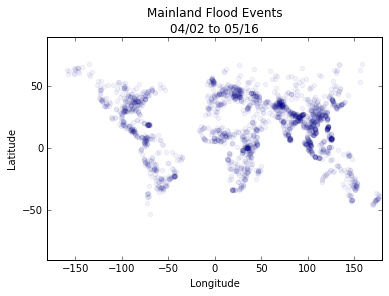

In [11]:
# frequency of floods across the world
x = df['Centroid X']
y = df['Centroid Y']

plt.scatter(x, y, alpha=0.05)
plt.title('Mainland Flood Events\n04/02 to 05/16')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim((-180, 180))
plt.ylim((-90, 90))
plt.savefig(dir_figures + 'floods_events.png')

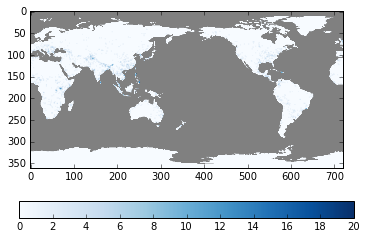

In [12]:
# create grace map showing flood frequency
flood_freq = np.zeros((720,360))

for i in range(df.shape[0]):
    lon = int(df['Centroid GRACE Lon'].iloc[i])
    lat = int(df['Centroid GRACE Lat'].iloc[i])
    
    if lon == 720:
        lon = 719
    
    size = 1 #4 for saturated map
    flood_freq[lon-size:lon+size+1, lat-size:lat+size+1] = \
        flood_freq[lon-size:lon+size+1, lat-size:lat+size+1] + 1
    
# replace 0's with NaNs
#flood_freq[flood_freq==0] = NaN

# transform grace maps
data = flipud(flood_freq.transpose())
data2 = flipud(grace_land_mask.transpose())
data2 = data2.astype(float)
data2[data2==1] = NaN

# display flood frequencies
plt.imshow(data, cmap=cm.Blues)
plt.colorbar(orientation='horizontal')

# display land mask
cmap = LinearSegmentedColormap.from_list('name',['gray','white'])
plt.imshow(data2, cmap=cmap)


plt.savefig(dir_figures + 'floods_events_freq.pdf')
plt.show()

## (2) Time Mapping for Flood Events

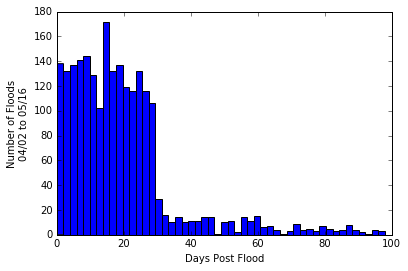

In [13]:
# plot histogram of differences b/w flood and GRACE-MASCON dates
plt.hist(df['Prior MASCON Diff-Days'], bins=50)
plt.ylabel('Number of Floods\n04/02 to 05/16')
plt.xlabel('Days Post Flood')
plt.savefig(dir_figures + 'floods_time_daysPostMascon.png')
plt.show()

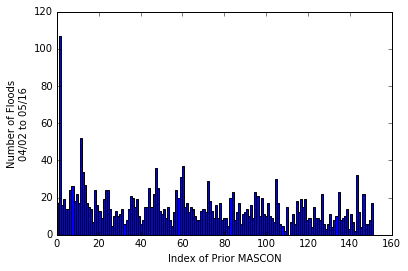

In [14]:
# plot histogram of GRACE MASCON time indexes of floods
plt.hist(df['Prior MASCON Index'], bins = tps)
plt.ylabel('Number of Floods\n04/02 to 05/16')
plt.xlabel('Index of Prior MASCON')
plt.savefig(dir_figures + 'floods_time_mappedMasconIndex.png')
plt.show()

##  (3) GRACE LWE for Complete Dataset

In [15]:
# plot_grace_complete_dataset_histogram: Plots grace metrics for entire dataset as a histogram
#
# Parameters:
# metric_mascon: GRACE MASCON brick with metric values
# metric_description: to be used in x-axis title

def plot_grace_complete_dataset_histogram(metric_description, metric_mascon, num_bins=50):
    
    # convert GRACE metric values to Pandas Series
    d1, d2, d3 = shape(metric_mascon)
    metric_series = pd.Series(data = metric_mascon.reshape(d1*d2*d3))
    
    # remove NaNs
    metric_series = metric_series[~pd.isnull(metric_series)];
    
    # histogram
    y,_,_ = plt.hist(metric_series, bins=num_bins)
    plt.title('Ground Water Level for Entire GRACE Mission')
    plt.xlabel(metric_description)
    plt.ylabel('Number Grid Cells\n04/02 to 05/16')
    
    # add mean and median lines
    y_max = int(y.max())
    metric_median = median(metric_series)
    plt.plot( [metric_median]*y_max , range(y_max), 'r', linewidth=1.5)
    
    plt.savefig(dir_figures + 'floods_entireGRACE_' + metric_description)
    plt.show()

### (3a) Numerical Features (un-ranked)

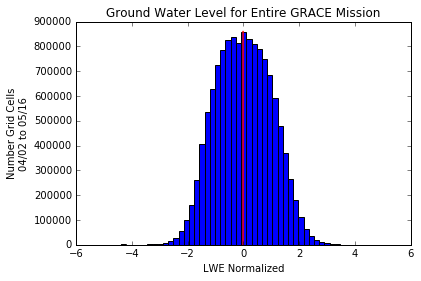

In [16]:
plot_grace_complete_dataset_histogram('LWE Normalized', grace_lwe_norm)

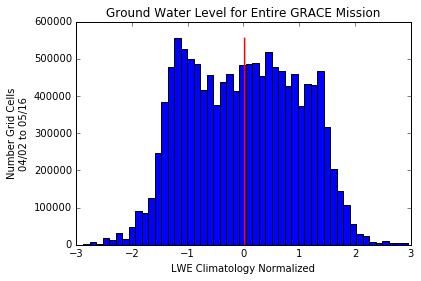

In [17]:
plot_grace_complete_dataset_histogram('LWE Climatology Normalized', grace_lwe_clim_norm)

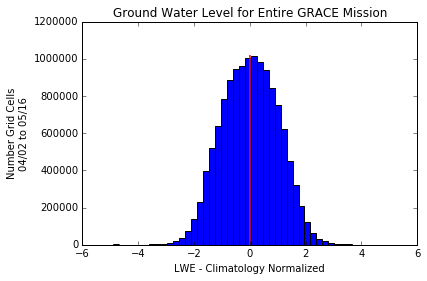

In [18]:
plot_grace_complete_dataset_histogram('LWE - Climatology Normalized', grace_lwe_noClim_norm)

### (3b) Ordinal Features (ranked)

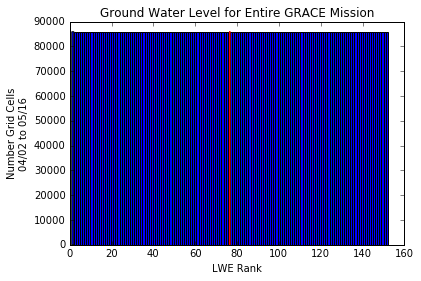

In [19]:
plot_grace_complete_dataset_histogram('LWE Rank', grace_lwe_rank, 152)

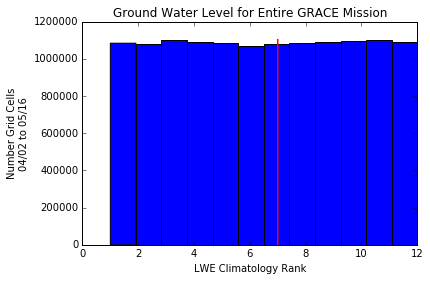

In [20]:
plot_grace_complete_dataset_histogram('LWE Climatology Rank', grace_lwe_clim_rank,12)

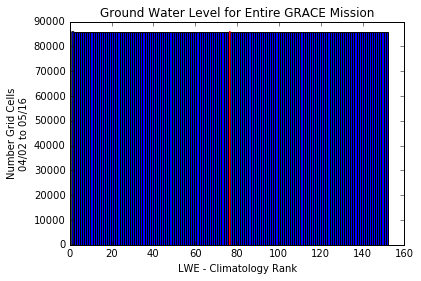

In [21]:
plot_grace_complete_dataset_histogram('LWE - Climatology Rank', grace_lwe_noClim_rank, 152)

## (4) GRACE LWE for Flood Events

### (4a) Numerical Features (un-ranked)

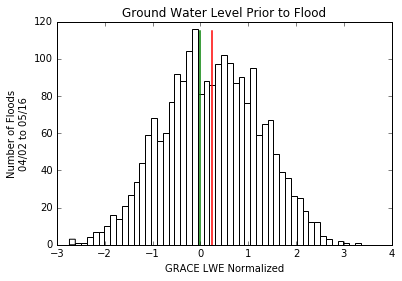

In [22]:
plot_grace_feature_histogram('GRACE LWE Normalized', df['GRACE lwe norm'])

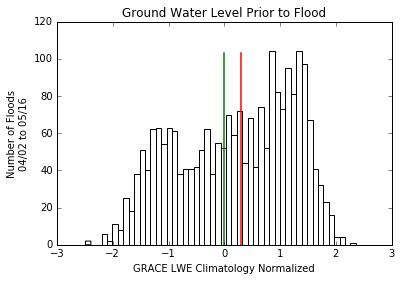

In [23]:
plot_grace_feature_histogram('GRACE LWE Climatology Normalized', df['GRACE lwe clim norm'])

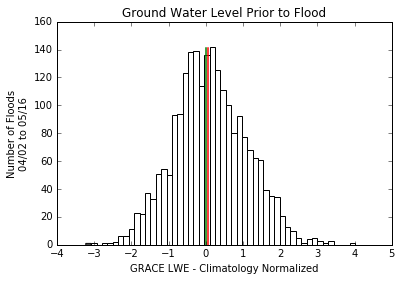

In [24]:
plot_grace_feature_histogram('GRACE LWE - Climatology Normalized', df['GRACE lwe noClim norm'])

### (4b) Ordinal Features (ranked)

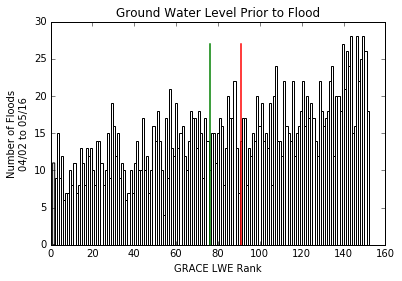

In [25]:
plot_grace_feature_histogram('GRACE LWE Rank', df['GRACE lwe rank'],\
                             num_bins=152, middle_value=76)

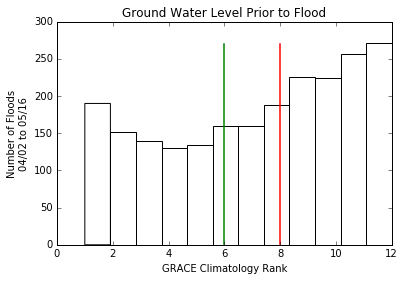

In [26]:
plot_grace_feature_histogram('GRACE Climatology Rank', df['GRACE lwe clim rank'],
                             num_bins=12, middle_value=6)

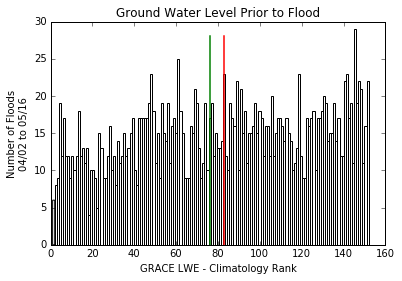

In [27]:
plot_grace_feature_histogram('GRACE LWE - Climatology Rank', df['GRACE lwe noClim rank'],\
                             num_bins=152, middle_value=76)

# Functions

In [ ]:
# co-ordinates
d1 = 200
d2 = 600
grace = grace_lwe_climRemStd_adj
climatology = grace_lwe_climatology_adj
    
# create timeseries
grace_timeseries = grace[d1,d2,:]
climatology_timeseries = climatology[d1,d2,:]

# find floods at grid location

    
# plot timeseries
plt.subplot(2,1,1)
plt.plot(grace_timeseries)
plt.subplot(2,1,2)
plt.plot(climatology_timeseries)

a = plt.show()